In [1]:
#traning data for super resolution

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import grafteaux as G


X, Y, U, V,Swirl, Cond,Prof, SwirlFiltPro, SwirlFiltRet, SwirlFilt = G.init_data()
Umean = Prof['U']


current path : C:\Users\Kommalapati sahil\Anaconda3\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


0.2439601862683396


In [3]:
umean2  = np.array([Umean[:,0] for i in range(U.shape[1])]).T
umean2.shape



(123, 242)

In [4]:
def rf(f):
    return [f[len(f)-i-1] for i in range(len(f))]



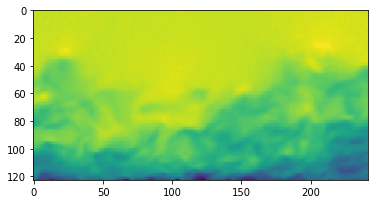

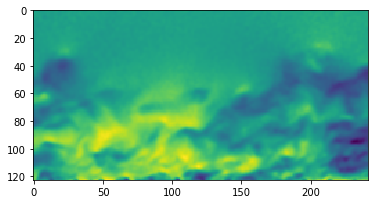

In [5]:
f1 = U[:,:,0]
plt.figure()
plt.imshow(rf(f1))
plt.figure()
plt.imshow(rf(f1-umean2))

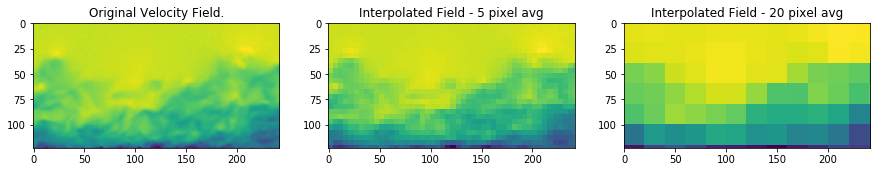

In [6]:
#maintain the shape 
#replace by averages of square tiles
#take care of corners

def lowRes(pt, dim):
    '''
    input pt - Field to be converted to lower resolution
    dim - the size of the square tile which does average pooling
    return pt_ - low resolution field. 
    '''
    pt_ = np.zeros(pt.shape)
    for i in range(len(pt)):
        for j in range(len(pt[i])):
            if i< len(pt) and j < len(pt[i]): 
                pt_[i,j] = np.mean(pt[i//dim*dim:i//dim*dim+dim, j//dim*dim: j//dim*dim+dim])
            elif i>= len(pt): pt_[i,j] = np.mean(pt[i//dim*dim:, j//dim*dim: j//dim*dim+dim])
            else:             pt_[i,j] = np.mean(pt[i//dim*dim: i//dim*dim+dim, j//dim*dim:])
    
    return pt_

#function to get the information content in the 
#reduced image. 


pt = rf(U[:,:,0])

pt2 = lowRes(np.array(pt), 5)
pt3 = lowRes(np.array(pt), 20)


plt.figure(figsize = (15,10))
plt.subplot(1,3,1)
plt.imshow(pt/np.max(pt))
plt.title('Original Velocity Field.')
plt.subplot(1,3,2)
plt.imshow(pt2)
plt.title('Interpolated Field - 5 pixel avg')
plt.subplot(1,3,3)
plt.imshow(pt3)
plt.title('Interpolated Field - 20 pixel avg')
plt.show()



In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow import keras

In [8]:
data_ins = []
data_outs = []

dim = 15
from tqdm import tqdm 
for i in tqdm(range(750)):
    #print(f'{i} done.')
    
    c_frame = U[:,:,i]-umean2
    c_frame = c_frame/np.nanmax(c_frame)
    
    do = (c_frame).flatten()
    di = lowRes(c_frame,5).flatten()
    data_ins.append(np.nan_to_num(di))
    data_outs.append(np.nan_to_num(do))

100%|██████████| 750/750 [04:47<00:00,  2.61it/s]


In [9]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(data_ins, data_outs, test_size=0.1, shuffle= True)

In [10]:

input_shape = pt2.flatten().shape
print(input_shape)

(29766,)


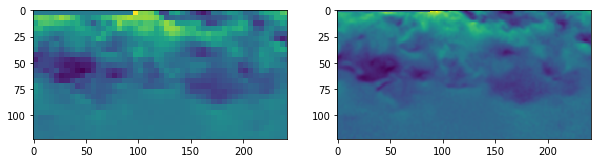

In [11]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(np.array(x_train[0]).reshape(pt2.shape))
plt.subplot(1,2,2)
plt.imshow(np.array(y_train[0]).reshape(pt2.shape))


In [12]:

from tensorflow.keras.backend import sigmoid
from tensorflow.python.keras.utils.generic_utils import get_custom_objects 
from tensorflow.keras.layers import Activation 

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)}) 


In [13]:
!python -m pip install -q -U keras-tuner
import kerastuner as kt

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [14]:
#buld a sd 

#build and train a model 
from tensorflow.keras import initializers


def model_builder(hp):
    
    
    
    hp_units1 = hp.Int('units-H1', min_value = 32, max_value = 512, step = 32)
    hp_units2 = hp.Int('units-H2', min_value = 32, max_value = 512, step = 32)
    hp_doH1 = hp.Choice('learning_rate', values = [5e-1, 31e-2, 1e-3]) 
    
    model = keras.Sequential([
        
        keras.Input(shape=input_shape),
        keras.layers.Dense(units = hp_units1,
                           activation = 'relu',
                           kernel_regularizer = keras.regularizers.l2(1e-7),
                           bias_initializer=initializers.Constant(0.1)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(hp_doH1),
        keras.layers.Dense(units = hp_units2, 
                           activation='relu',
                           kernel_regularizer = keras.regularizers.l2(1e-7),
                           bias_initializer=initializers.Constant(0.1)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(input_shape[0])
        
    ])
    
    hp_lr = hp.Choice('lr', values = [1e-2, 1e-3, 1e-4])
    adam = tf.keras.optimizers.Adam(lr=hp_lr,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=None,
                                decay=0.3,
                                amsgrad=False)

    model.compile(optimizer=adam ,
                  loss='mean_squared_error',
                  metrics=['mse'])

    return model 


tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 50,
                     factor = 3)

W1001 09:13:21.612041  1388 deprecation.py:506] From C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
      def on_train_end(*args, **kwargs):
            IPython.display.clear_output(wait = True)


In [17]:
tuner.search(np.array(x_train), np.array(y_train), epochs = 10,
             validation_data = (np.array(x_valid), np.array(y_valid)))
#,
#             callbacks = [ClearTrainingOutput()])


Train on 675 samples, validate on 75 samples
Epoch 1/2
672/675 [============================>.] - ETA: 25s - loss: 0.0989 - mean_squared_error: 0.098 - ETA: 14s - loss: 0.0912 - mean_squared_error: 0.091 - ETA: 10s - loss: 0.0834 - mean_squared_error: 0.083 - ETA: 8s - loss: 0.0791 - mean_squared_error: 0.079 - ETA: 6s - loss: 0.0751 - mean_squared_error: 0.07 - ETA: 5s - loss: 0.0742 - mean_squared_error: 0.07 - ETA: 5s - loss: 0.0714 - mean_squared_error: 0.07 - ETA: 4s - loss: 0.0697 - mean_squared_error: 0.06 - ETA: 4s - loss: 0.0702 - mean_squared_error: 0.07 - ETA: 3s - loss: 0.0690 - mean_squared_error: 0.06 - ETA: 3s - loss: 0.0675 - mean_squared_error: 0.06 - ETA: 2s - loss: 0.0659 - mean_squared_error: 0.06 - ETA: 2s - loss: 0.0652 - mean_squared_error: 0.06 - ETA: 2s - loss: 0.0642 - mean_squared_error: 0.06 - ETA: 1s - loss: 0.0631 - mean_squared_error: 0.06 - ETA: 1s - loss: 0.0623 - mean_squared_error: 0.06 - ETA: 1s - loss: 0.0615 - mean_squared_error: 0.06 - ETA: 0s - l

UnknownError: Failed to WriteFile: .\untitled_project\trial_2ee59450cc5ae299486e670d0b543c44\checkpoints\epoch_0\checkpoint_temp_0d1ce258e3fe43b791f76ebab27c681c/part-00000-of-00002.data-00000-of-00001.tempstate12805273590282339316 : There is not enough space on the disk.
; Unknown error
	 [[node SaveV2 (defined at C:\Users\Kommalapati sahil\Anaconda3\lib\site-packages\kerastuner\engine\multi_execution_tuner.py:96) ]]

Errors may have originated from an input operation.
Input Source operations connected to node SaveV2:
 dense/bias/Read/ReadVariableOp (defined at <ipython-input-14-10dc89f1f6a7>:29)

Original stack trace for 'SaveV2':
  File "C:\Users\Kommalapati sahil\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Kommalapati sahil\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelapp.py", line 563, in start
    self.io_loop.start()
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Kommalapati sahil\Anaconda3\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "C:\Users\Kommalapati sahil\Anaconda3\lib\asyncio\base_events.py", line 1771, in _run_once
    handle._run()
  File "C:\Users\Kommalapati sahil\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3242, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-6383f538bde8>", line 2, in <module>
    validation_data = (np.array(x_valid), np.array(y_valid)))
  File "C:\Users\Kommalapati sahil\Anaconda3\lib\site-packages\kerastuner\engine\base_tuner.py", line 130, in search
    self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Kommalapati sahil\Anaconda3\lib\site-packages\kerastuner\tuners\hyperband.py", line 387, in run_trial
    super(Hyperband, self).run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Kommalapati sahil\Anaconda3\lib\site-packages\kerastuner\engine\multi_execution_tuner.py", line 96, in run_trial
    history = model.fit(*fit_args, **copied_fit_kwargs)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training_arrays.py", line 419, in model_iteration
    callbacks.on_epoch_end(epoch, epoch_logs)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\callbacks.py", line 311, in on_epoch_end
    callback.on_epoch_end(epoch, logs)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\callbacks.py", line 969, in on_epoch_end
    self._save_model(epoch=epoch, logs=logs)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\callbacks.py", line 998, in _save_model
    self.model.save_weights(filepath, overwrite=True)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\network.py", line 1331, in save_weights
    self._trackable_saver.save(filepath, session=session)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\training\tracking\util.py", line 1106, in save
    file_prefix=file_prefix_tensor, object_graph_tensor=object_graph_tensor)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\training\tracking\util.py", line 1054, in _save_cached_when_graph_building
    save_op = saver.save(file_prefix)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\training\saving\functional_saver.py", line 230, in save
    sharded_saves.append(saver.save(shard_prefix))
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\training\saving\functional_saver.py", line 72, in save
    return io_ops.save_v2(file_prefix, tensor_names, tensor_slices, tensors)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gen_io_ops.py", line 2059, in save_v2
    name=name)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [56]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]


IndexError: list index out of range

In [18]:
print(best_hps.get('units-H1'))
print(best_hps.get('units-H2'))
print(best_hps.get('learning_rate'))


NameError: name 'best_hps' is not defined

In [51]:
model = tuner.hypermodel.build(best_hps)
model.fit(np.array(x_train),np.array(y_train),
          epochs = 100, 
          batch_size = 128, 
          validation_data = (np.array(x_valid), np.array(y_valid)))

Train on 675 samples, validate on 75 samples
Epoch 1/100
675/675 [==============================] - ETA: 5s - loss: 0.0983 - mean_squared_error: 0.09 - ETA: 3s - loss: 0.0959 - mean_squared_error: 0.09 - ETA: 2s - loss: 0.0968 - mean_squared_error: 0.09 - ETA: 1s - loss: 0.0959 - mean_squared_error: 0.09 - ETA: 0s - loss: 0.0927 - mean_squared_error: 0.09 - 5s 8ms/sample - loss: 0.0917 - mean_squared_error: 0.0917 - val_loss: 0.0649 - val_mean_squared_error: 0.0649
Epoch 2/100
675/675 [==============================] - ETA: 2s - loss: 0.0902 - mean_squared_error: 0.09 - ETA: 2s - loss: 0.0846 - mean_squared_error: 0.08 - ETA: 1s - loss: 0.0816 - mean_squared_error: 0.08 - ETA: 0s - loss: 0.0777 - mean_squared_error: 0.07 - ETA: 0s - loss: 0.0752 - mean_squared_error: 0.07 - 4s 6ms/sample - loss: 0.0748 - mean_squared_error: 0.0748 - val_loss: 0.0621 - val_mean_squared_error: 0.0621
Epoch 3/100
675/675 [==============================] - ETA: 2s - loss: 0.0643 - mean_squared_error: 0.06 

KeyboardInterrupt: 

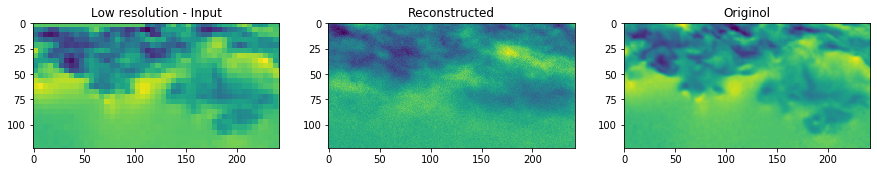

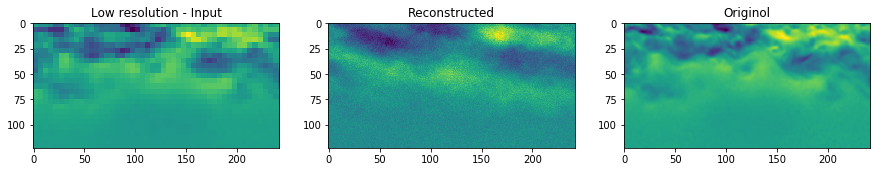

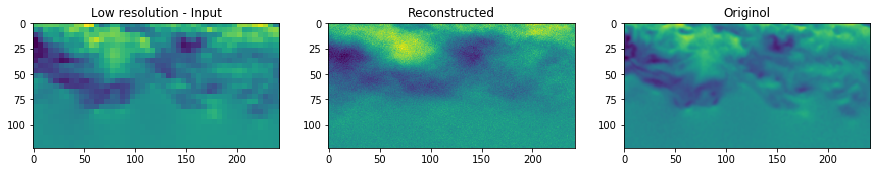

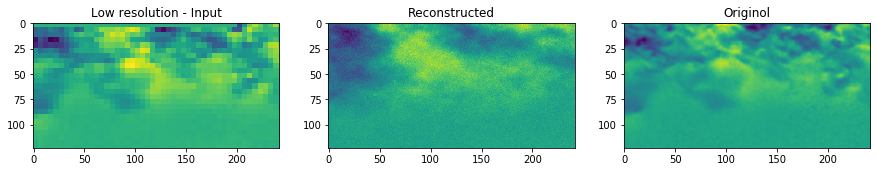

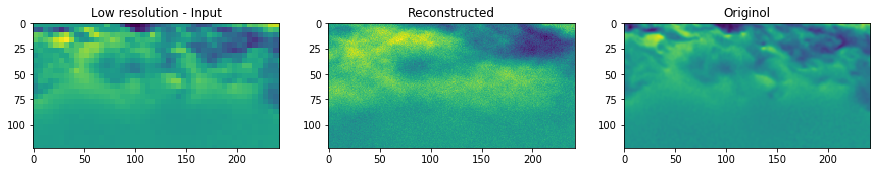

In [46]:
for i in range(5):
    plt.figure(figsize = (15,10))

    plt.subplot(1,3,1)
    plt.imshow(rf(x_valid[i].reshape(pt2.shape)))
    plt.title('Low resolution - Input')
    y_pred0 = model.predict(np.array([x_valid[i]]))

    plt.subplot(1,3,2)
    plt.imshow(rf(y_pred0.reshape(pt2.shape)))
    plt.title('Reconstructed')

    plt.subplot(1,3,3)
    plt.imshow(rf(y_valid[i].reshape(pt2.shape)))
    plt.title('Originol')
    plt.show()